In [2]:
import sys
import os
#sys.path.insert(0, os.path.abspath('..'))
#sys.path.insert(1, '/path/to/application/app/folder')
sys.path.append('./../sysid_pem_toolbox')

In [3]:
import sysid_pem as sid
import numpy as np
import scipy as sp
import control as ct
import matplotlib.pyplot as plt
import pandas as pd
import importlib

In [4]:
data1 = pd.read_excel("C:/Users/Arne/OneDrive - University of Calgary/Documents/Data/charging_cycles_selected.xlsx",sheet_name="cycle_11",header=0).to_numpy()
data2 = pd.read_excel("C:/Users/Arne/OneDrive - University of Calgary/Documents/Data/charging_cycles_selected.xlsx",sheet_name="cycle_38",header=0).to_numpy()
data3 = pd.read_excel("C:/Users/Arne/OneDrive - University of Calgary/Documents/Data/charging_cycles_selected.xlsx",sheet_name="cycle_123",header=0).to_numpy()
data4 = pd.read_excel("C:/Users/Arne/OneDrive - University of Calgary/Documents/Data/charging_cycles_selected.xlsx",sheet_name="cycle_200",header=0).to_numpy()


In [5]:
u = data4[:,0]
y = data4[:,1]

u -= u[0]
y -= y[0]

G_init: 
 5.183 z^6 + 6.113 z^5 + 5.202 z^4 + 5.634 z^3 + 4.591 z^2 + 5.154 z + 2.436
-----------------------------------------------------------------------------
z^6 - 0.02918 z^5 - 0.1656 z^4 + 0.1186 z^3 - 0.2261 z^2 + 0.1563 z - 0.03915

dt = 1

poles: [-0.90405727+0.j         -0.13282294+0.65986432j -0.13282294-0.65986432j
  0.48413513+0.j          0.35737207+0.26406815j  0.35737207-0.26406815j]
zeros: [ 0.53161779+0.77821162j  0.53161779-0.77821162j -0.32167822+0.86039088j
 -0.32167822-0.86039088j -0.91053646+0.j         -0.68891303+0.j        ]


c:\Users\Arne\miniconda3\envs\enel441\lib\site-packages\scipy\signal\_filter_design.py:1709: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


G_init: 
4.91 z^6 + 9.486 z^5 + 11.01 z^4 + 11.19 z^3 + 6.032 z^2 + 0.2717 z - 10.64
---------------------------------------------------------------------------
z^6 + 0.7631 z^5 - 0.1946 z^4 + 0.08493 z^3 - 0.5955 z^2 + 0.4742 z - 1.056

dt = 1

poles: [-1.4317321 +0.j         -0.51761161+0.8962657j  -0.51761161-0.8962657j
  0.93483666+0.j          0.38452344+0.76719486j  0.38452344-0.76719486j]
zeros: [-1.4317321 +0.j         -0.79689289+0.95050563j -0.79689289-0.95050563j
  0.20743434+1.1858999j   0.20743434-1.1858999j   0.67856574+0.j        ]


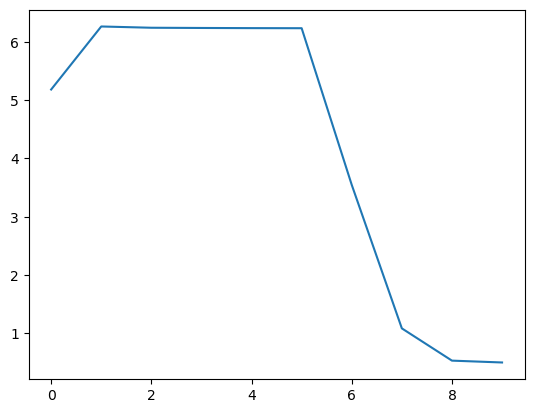

In [5]:
nf = 6
nb = 7
nc = 1
nd = 1
na = nf
nk = 0
n_arx = [na, nb, nk]
n_bj = [nb, nc, nd, nf, nk]

n_high_order = [10,10,nk]

g_imp_est, h_imp_est = sid.FIR_estimates_GH(n_high_order,y,u)

n_high_order2 = [10,0,nk]

g_imp_est2, h_imp_est2 = sid.FIR_estimates_GH(n_high_order2,y,u)

fig,ax = plt.subplots(1)
ax.plot(g_imp_est)
ax.plot(g_imp_est2,'--')

g_imp_est_zero_padded = np.concatenate((g_imp_est,np.zeros(10)))
#g_imp_est_zero_padded = g_imp_est


#theta_init_bj = sid.tf_realization_GH(g_imp_est_zero_padded,h_imp_est,n_bj)
thetaBA = sid.tf_realization_G(g_imp_est_zero_padded,[nf,nb,nk])
thetaCD = sid.tf_realization_H(h_imp_est,[nc,nd])
theta_init_bj = np.concatenate((thetaBA[0:nb], thetaCD, thetaBA[nb:nb+nf]))

G_init, H_init = sid.theta_2_tf_box_jenkins(theta_init_bj,n_bj,1)
tt,g_init = ct.impulse_response(G_init)

print('G_init:', G_init)
print('poles:', G_init.poles())
print('zeros:', G_init.zeros())

optimization_results_bj = sp.optimize.least_squares(sid.V_box_jenkins, theta_init_bj, jac=sid.jac_V_bj, args=(n_bj,y,u))
G_est, H_est = sid.theta_2_tf_box_jenkins(optimization_results_bj.x,n_bj,1)
tt,g_est = ct.impulse_response(G_est)

print('G_init:', G_est)
print('poles:', G_est.poles())
print('zeros:', G_est.zeros())


In [6]:
importlib.reload(sid)
#n_high_order1 = [10,10,nk]
#theta1 = sid.V_arx_lin_reg(n_high_order1,y,u)
n_high_order2 = [0,10,nk]
g_imp_est = sid.V_arx_lin_reg(n_high_order2,y,u)
#print(theta1)
#print(theta2)

g_imp_est_zero_padded = np.concatenate((g_imp_est[0:9],np.zeros(10)))

theta_init_oe_fir = sid.tf_realization_G(g_imp_est_zero_padded,[nf,nb,nk])
G_init, H_init = sid.theta_2_tf_oe(theta_init_oe_fir,[nb,nf,nk],1)
tt,g_init = ct.impulse_response(G_init)

print(theta_init_oe_fir)
print(G_init)
print(G_init.poles())

theta_init_oe_arx = sid.get_initial_estimate_output_error_ARX([nb,nf,nk], y, u)
G_init2, H_init2 = sid.theta_2_tf_oe(theta_init_oe_arx,[nb,nf,nk],1)
tt,g_init2 = ct.impulse_response(G_init2)

print(theta_init_oe_arx)
print(G_init2)
print(G_init2.poles())


optimization_results_oe = sp.optimize.least_squares(sid.V_oe, theta_init_oe_fir, jac=sid.jac_V_oe, args=([nb,nf,nk],y,u))
G_est, H_est = sid.theta_2_tf_oe(optimization_results_oe.x,[nb,nf,nk],1)
tt,g_est = ct.impulse_response(G_est)

print(optimization_results_oe.x)
print(G_est)
print(G_est.poles())

optimization_results_oe2 = sp.optimize.least_squares(sid.V_oe, theta_init_oe_arx, jac=sid.jac_V_oe, args=([nb,nf,nk],y,u))
G_est2, H_est = sid.theta_2_tf_oe(optimization_results_oe2.x,[nb,nf,nk],1)
tt,g_est2 = ct.impulse_response(G_est2)

print(optimization_results_oe2.x)
print(G_est2)
print(G_est2.poles())







[ 4.47682748e+00  6.30604830e+00  5.34867344e+00  4.92708205e+00
  5.13863709e+00  5.22271507e+00  2.49951078e+00  9.09923964e-03
 -2.14081251e-01 -8.60284350e-03  4.99507356e-02 -1.21535018e-03
 -7.05491863e-03]

     4.477 z^6 + 6.306 z^5 + 5.349 z^4 + 4.927 z^3 + 5.139 z^2 + 5.223 z + 2.5
------------------------------------------------------------------------------------
z^6 + 0.009099 z^5 - 0.2141 z^4 - 0.008603 z^3 + 0.04995 z^2 - 0.001215 z - 0.007055

dt = 1

[ 0.42809607+0.j          0.3263774 +0.30047989j  0.3263774 -0.30047989j
 -0.35009256+0.30375597j -0.35009256-0.30375597j -0.38976499+0.j        ]
[ 5.16723154 -4.11648569  2.5889694  -1.13038267  0.54480617  0.34229243
 -2.23574361 -2.00377219  1.71686789 -1.08390906  0.55547585 -0.15868719
 -0.01075018]

5.167 z^6 - 4.116 z^5 + 2.589 z^4 - 1.13 z^3 + 0.5448 z^2 + 0.3423 z - 2.236
----------------------------------------------------------------------------
 z^6 - 2.004 z^5 + 1.717 z^4 - 1.084 z^3 + 0.5555 z^2 - 0.1587 z -

(-30.0, 30.0)

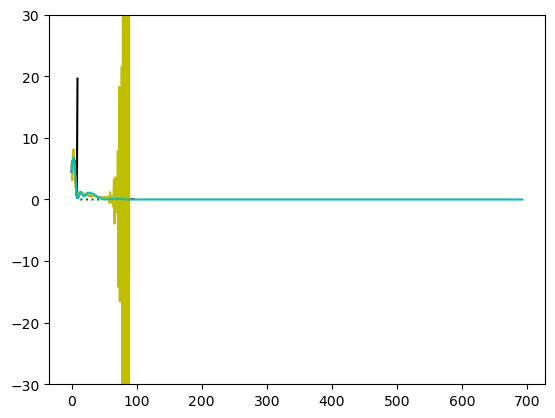

In [7]:
fig,ax=plt.subplots(1)
#ax.plot(theta1[n_high_order1[0]:n_high_order1[1]+n_high_order1[0]],'k')
#ax.plot(theta1,'k')
#ax.plot(theta2[n_high_order2[0]:n_high_order2[1]],'--')
ax.plot(g_imp_est, 'k')
ax.plot(g_init, 'g:')
ax.plot(g_init2, 'r--')
ax.plot(g_est, 'y')
ax.plot(g_est2, 'c')

ax.set_ylim([-30, 30])

In [62]:
print(optimization_results_oe)

 active_mask: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
        cost: 2.040372446352566
         fun: array([ 0.        , -0.01452208, -0.03039885, -0.04440546, -0.05772543,
       -0.07045317, -0.08249474, -0.09508896, -0.10558462, -0.11113787,
       -0.22874378,  0.27659036,  0.02246846, -0.28054165, -0.29039208,
        0.06362807,  0.27634986,  0.26490878,  0.23139858,  0.19091838,
        0.13254028,  0.05758961, -0.02353248, -0.0881369 , -0.110237  ,
       -0.09396191, -0.10632945, -0.16294078, -0.23119047, -0.29831804,
       -0.35583493, -0.39726312, -0.41356076, -0.40080678, -0.36294428,
       -0.31015662, -0.24812676, -0.17741417, -0.10313024, -0.03561532,
        0.01990338,  0.07136745,  0.12504696,  0.18552712,  0.25431675,
        0.31928102,  0.36831449,  0.39665986,  0.41474295,  0.41333476,
        0.40443076,  0.39075621,  0.36115647,  0.3304465 ,  0.30139691,
        0.25243667,  0.22116695,  0.18164055,  0.13141383,  0.10309572,
        0.067595

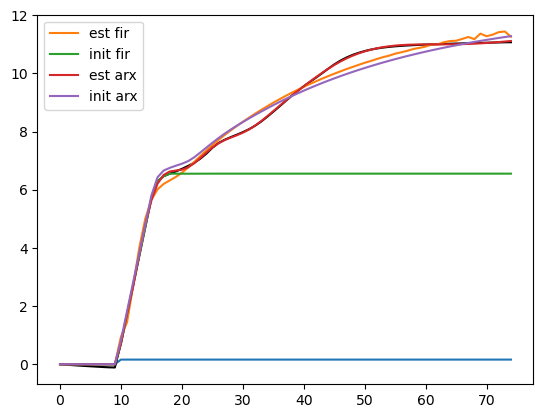

In [8]:

tt,y_sim_est = ct.forced_response(G_est,U=u-u[0])
tt,y_sim_init = ct.forced_response(G_init,U=u-u[0])
tt,y_sim_est2 = ct.forced_response(G_est2,U=u-u[0])
tt,y_sim_init2 = ct.forced_response(G_init2,U=u-u[0])

#y_hat = sid.y_hat_box_jenkins(optimization_results_bj.x, n_bj, y-y[0], u-u[0])


#y_hat_init = sid.y_hat_box_jenkins(theta_init_bj, n_bj, y-y[0], u-u[0])

fig,ax = plt.subplots(1)
ax.plot(u-u[0])
ax.plot(y-y[0],'k')
#ax.plot(y_hat_init,'r--')
#ax.plot(y_hat,'g:')
ax.plot(y_sim_est, label='est fir')
ax.plot(y_sim_init, label='init fir')
ax.plot(y_sim_est2, label='est arx')
ax.plot(y_sim_init2, label='init arx')
#ax.set_ylim([0,30])
ax.legend()

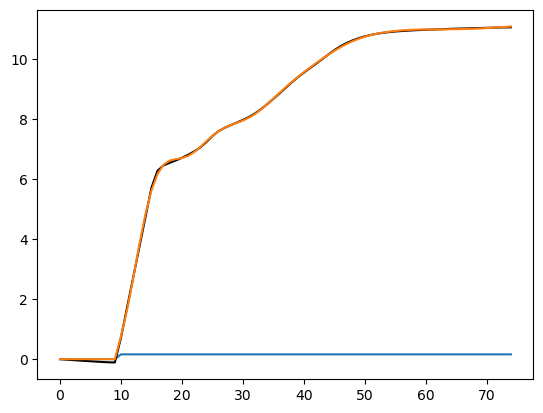

In [17]:
importlib.reload(sid)
n_oe = np.array([6,5,0])
n_high_order_oe = 10
optimization_results_oe = sid.estimate_oe(n_oe,n_high_order_oe,y,u)
G_est, H_est = sid.theta_2_tf_oe(optimization_results_oe.x,n_oe,1)
tt,y_sim_est = ct.forced_response(G_est,U=u-u[0])
fig,ax = plt.subplots(1)
ax.plot(u-u[0])
ax.plot(y-y[0],'k')
ax.plot(y_sim_est, label='est fir')

C:\Users\Arne\AppData\Local\Temp\ipykernel_15952\1667608770.py:3: RuntimeWarning: divide by zero encountered in divide
  G_est3 = Y/U


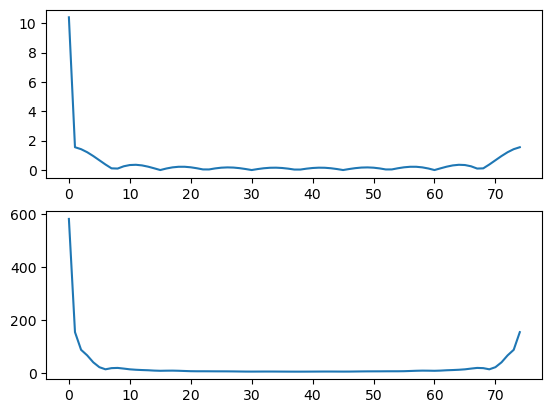

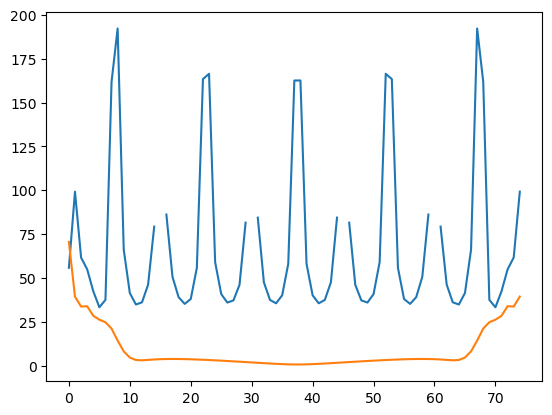

In [13]:
U = np.fft.fft(u)
Y = np.fft.fft(y)
G_est3 = Y/U

N = u.shape[0]
G_est2b = np.fft.fft(g_est2[0:N])

fig,ax = plt.subplots(2,1)
ax[0].plot(np.abs(U))
ax[1].plot(np.abs(Y))

fig,ax = plt.subplots(1)
ax.plot(np.abs(G_est3))
ax.plot(np.abs(G_est2b))

In [8]:
importlib.reload(sid)
n_oe = [5,4,0]
theta_fir = sid.V_arx_lin_reg([0, 10, 0],y,u)
theta_init_oe = sid.get_initial_estimate_output_error(n_oe, 10, y,u)
G_init, H_init = sid.theta_2_tf_oe(theta_init_oe,n_oe,1)
tt,g_init = ct.impulse_response(G_init)

fig,ax = plt.subplots(1)
ax.plot(g_init[0:10])
ax.plot(theta_fir)

AttributeError: module 'sysid_pem' has no attribute 'get_initial_estimate_output_error'

In [15]:
print(type(n_oe[0]))

<class 'numpy.int32'>


In [ ]:
def V_oe_time_domain(theta, n, y, u, Ts):
    np = n[0]
    c_vec = theta[0:np] + 1j*theta[np:2*np]
    p_vec = theta[2*np:3*np] + 1j*theta[3*np:4*np]

    N = u.shape[0]
    t = np.linspace(0,N*Ts-Ts,N)
    g_imp = np.zeros(N)
    for ii in range(np):
        g_imp += c_vec[ii]*np.exp(p_vec[ii]*t)
    y_hat = np.convolve(g_imp,u,mode='same')

    return y-y_hat
    


[0.  0.5]
[[0.   0.   0.   0.   0.  ]
 [0.   0.5  0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.8  0.  ]
 [0.   0.   0.   0.   2.24]]


In [18]:
np.array([1, 1]) + 1j*np.array([2, 3])

array([1.+2.j, 1.+3.j])

In [43]:
#Jury table
def print_jury_table(den):
    r1 = den
    r2 = np.flip(den)
    r3 = r1 - r2*r1[-1]/r2[-1]
    r4 = np.flip(r3[0:-1])
    r5 = r3[0:-1] - r4*r3[-2]/r4[-1]
    r6 = np.flip(r5[0:-1])

    print(r1)
    print(r2)
    print(r3)
    print(r4)
    print(r5)
    print(r6)

In [44]:
def linear_least_squares(theta,A,b):
    return (A @ theta - b)

def linear_least_squares2(theta,A,b):
    return np.sum((A @ theta - b)**2)

def jac2(theta,A,b):
    return 2*A.T @ ( A@theta - b) 

def my_derivative(theta,A,b):
    jac = np.empty(theta.shape[0])
    for ii in range(theta.shape[0]):
        theta_p1 = theta.copy()
        theta_p1[ii] += 0.001
        jac[ii] = (linear_least_squares2(theta_p1,A,b) - linear_least_squares2(theta,A,b) )/0.001
    return jac


In [45]:
def tf_realization_GH(g,h,n):
    
    nb = n[0]
    nc = n[1]
    nd = n[2]
    na = n[3]
    nk = n[4]

    nh = h.shape[0]-1
    ng = g.shape[0]-nk
    
    # Create Toeplitz matrix for G transfer function realization
    Cg = np.array(sp.linalg.toeplitz(np.concatenate(([0],g[nk:nk+ng-1])),r=np.zeros(na)))
    Meye = np.concatenate((np.eye(nb), np.zeros((ng-nb,nb))),axis=0)
    M = np.concatenate((Meye,-Cg),axis=1)
    thetaBA = np.linalg.inv( M.T @ M ) @ (M.T @ g[nk:ng+nk] )
    
    theta_init = np.zeros(nb+na)
    bounds = np.ones((nb+na,2))
    bounds[:,0] *= -np.inf
    bounds[:,1] *= np.inf
    bounds[nb+na-1,0] = 0
    bounds_x = (bounds[:,0], bounds[:,1])
    print( bounds_x )
    bounds_x2 = bounds.tolist()
    print(bounds_x2)

    print(jac2(theta_init,M,g[nk:ng+nk]))
    print(my_derivative(theta_init,M,g[nk:ng+nk]))

    optimization_results1 = sp.optimize.least_squares(linear_least_squares, theta_init, args= (M, g[nk:ng+nk]), bounds=bounds_x)
    optimization_results2 = sp.optimize.minimize(linear_least_squares2, theta_init, args= (M, g[nk:ng+nk]), bounds=bounds_x2, jac=jac2)


    #print(optimization_results1)
    #print(optimization_results2)
    print(thetaBA)
    print(optimization_results1.x)
    print(optimization_results2.x)



    print(np.sum(linear_least_squares(optimization_results1.x,M,g[nk:ng+nk])**2))
    print(np.sum(linear_least_squares(optimization_results2.x,M,g[nk:ng+nk])**2))
    print(linear_least_squares2(optimization_results1.x,M,g[nk:ng+nk]))
    print(linear_least_squares2(optimization_results2.x,M,g[nk:ng+nk]))

    # Create Toeplitz matrix for H transfer function realization
    if nc==0 and nd==0:
        thetaCD = []
    elif nc>0 and nd>0:
        Ch = np.array(sp.linalg.toeplitz(h[0:nh],r=np.concatenate(([1],np.zeros(nd-1)))))
        Meye = np.concatenate((np.eye(nc), np.zeros((nh-nc,nc))),axis=0)
        M = np.concatenate((Meye,-Ch),axis=1)
        thetaCD = np.linalg.inv( M.T @ M ) @ (M.T @ h[1:nh+1] )

    theta = np.concatenate((thetaBA[0:nb], thetaCD, thetaBA[nb:nb+na]))
    theta1 = np.concatenate((optimization_results1.x[0:nb], thetaCD, optimization_results1.x[nb:nb+na]))
    theta2 = np.concatenate((optimization_results2.x[0:nb], thetaCD, optimization_results2.x[nb:nb+na]))

    G_est, H_est = sid.theta_2_tf_box_jenkins(theta,n_bj,1)
    G_est1, H_est1 = sid.theta_2_tf_box_jenkins(theta1,n_bj,1)
    G_est2, H_est2 = sid.theta_2_tf_box_jenkins(theta2,n_bj,1)

    print(G_est)
    print(G_est.poles())
    print(G_est1)
    print(G_est1.poles())
    print(G_est2)
    print(G_est2.poles())

    return theta

theta_init_bj = tf_realization_GH(g_imp_est_zero_padded,h_imp_est,n_bj)



(array([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,   0.]), array([inf, inf, inf, inf, inf, inf, inf, inf, inf]))
[[-inf, inf], [-inf, inf], [-inf, inf], [-inf, inf], [-inf, inf], [-inf, inf], [-inf, inf], [-inf, inf], [0.0, inf]]
[-26.65048036 -47.21749862  -3.83126769  -2.49044993  -1.93421315
 731.26999744 118.96759643  86.09581526  68.76195494]
[-26.64948036 -47.21649862  -3.83026769  -2.48944993  -1.93321315
 732.01296758 119.71056658  86.8387854   69.50492508]
[ 1.33252402e+01  1.21373560e+01 -1.60386894e+01  2.61781300e+00
 -1.85562282e+00 -8.60877039e-01  1.77850976e-01 -8.83380619e-02
 -4.42018224e-04]
[ 1.33252402e+01  1.21355865e+01 -1.59258915e+01  2.70261832e+00
 -2.04644590e+00 -8.61009831e-01  1.86551225e-01 -9.73692153e-02
  1.03675968e-09]
[ 13.32523967  12.03582972 -15.96629758   2.88797237  -2.11037354
  -0.86849544   0.19678187  -0.10051175   0.        ]
0.11394569628933002
0.11395454937774839
0.11394569628933002
0.11395454937774839

13.33 z^4 + 12.14 z^3 - 16.0

In [46]:
optimization_results_bj = sp.optimize.least_squares(sid.V_box_jenkins, theta_init_bj, jac=sid.jac_V_bj, args=(n_bj,y,u))
G_est, H_est = sid.theta_2_tf_box_jenkins(optimization_results_bj.x,n_bj,1)
tt,g_est = ct.impulse_response(G_est)

print('G_init:', G_est)
print('poles:', G_est.poles())
print('zeros:', G_est.zeros())

G_init: 
13.29 z^4 + 16.28 z^3 - 17.78 z^2 - 9.533 z + 3.389
---------------------------------------------------
 z^4 - 0.5465 z^3 - 0.51 z^2 + 0.1727 z + 0.002509

dt = 1

poles: [ 0.89689026+0.j -0.64645583+0.j  0.31000542+0.j -0.01396106+0.j]
zeros: [-1.71028104+0.j -0.64884739+0.j  0.87086914+0.j  0.2638134 +0.j]


[13.32524018 23.60874931  1.91563385  1.24522497  0.96710657  0.78884224
  0.67773731  0.59372934  0.52325848  0.41427993]


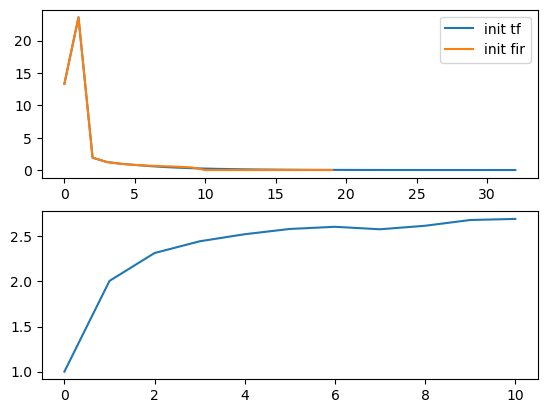

In [49]:
print(g_imp_est)
fig,ax = plt.subplots(2,1)
ax[0].plot(g_init,label='init tf')
ax[0].plot(g_imp_est_zero_padded, label='init fir')
#ax[0].plot(g_est, label='final')
ax[0].legend()
#ax[1].plot(g_init[0:15])
ax[1].plot(h_imp_est)

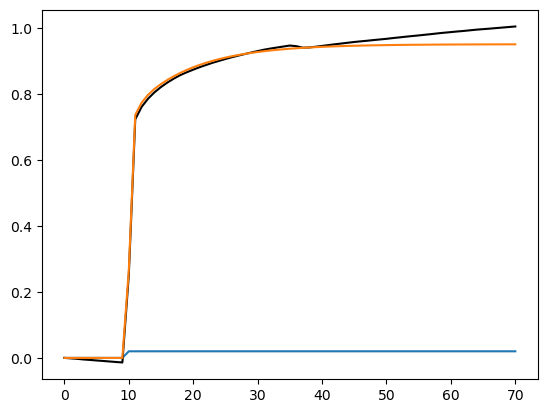

In [51]:
B,C,D,F = sid.theta_2_BCDF(optimization_results_bj.x,n_bj)
G_theta = ct.tf(B, F, True)
tt,y_sim = ct.forced_response(G_theta,U=u-u[0])
#y_hat = sid.y_hat_box_jenkins(optimization_results_bj.x, n_bj, y-y[0], u-u[0])


#y_hat_init = sid.y_hat_box_jenkins(theta_init_bj, n_bj, y-y[0], u-u[0])

fig,ax = plt.subplots(1)
ax.plot(u-u[0])
ax.plot(y-y[0],'k')
#ax.plot(y_hat_init,'r--')
#ax.plot(y_hat,'g:')
ax.plot(y_sim)